# Gaussian Process with Noise

In [6]:
import numpy as onp
import matplotlib.pyplot as plt
import seaborn
plt.style.use('seaborn-notebook')

## Generate function with noise

$$ y = m x + \mathcal{N}(\mu, \sigma) $$

In [3]:
def f(x):
    y = 0.80 * x + onp.random.normal(0.0, 1.0)
    return y
f = onp.vectorize(f)

In [4]:
x_train = onp.random.choice(onp.linspace(0, 10, 100), 10)
x_test = onp.random.choice(onp.linspace(0, 10, 100), 5)
y_train = f(x_train)

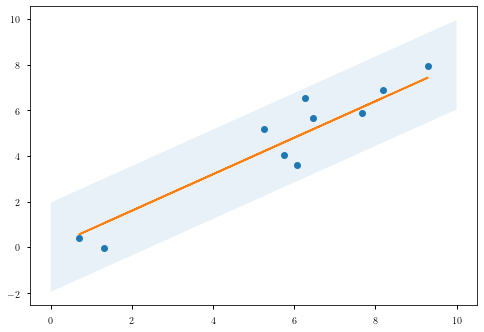

In [9]:
plt.plot(x_train, y_train, 'o')
plt.plot(x_train, 0.80*x_train)
x_space = onp.linspace(0, 10, 100)
plt.fill_between(x_space, 0.80*x_space + 1.96*1.0, 0.80*x_space - 1.96*1.0, alpha=0.1)
plt.show()

## Train GP to estimate mean and uncertanity

In [15]:
import jax.numpy as np
from jax import grad, jit, vmap
import jax.scipy as scipy
from jax import random
import jax.ops as ops
key = random.PRNGKey(0)

In [11]:
# Vectorizes kernel computation
def cov_map(cov_func, xs, xs2=None, params=None):
    if params is None:
        if xs2 is None:
            return vmap(lambda x:vmap(lambda y: cov_func(x, y))(xs))(xs)
        else:
            return vmap(lambda x: vmap(lambda y: cov_func(x, y))(xs))(xs2).T
    else:
        if xs2 is None:
            return vmap(lambda x:vmap(lambda y: cov_func(x, y))(xs))(xs)
        else:
            return vmap(lambda x: vmap(lambda y: cov_func(x, y))(xs))(xs2).T        

`vmap` function by defaults maps over the 0 index axis and this dictates the shape of the input data. Default option can be updated to support different array shapes.

### Kernel Functions

In [7]:
def sqrd_exp(x, xs, params):
    return params["sigma_kernel"]**2 * np.exp(-np.sum((x-xs)**2)/(2*params["lengthscale"]))

**Test kernel implementation**

In [8]:
x = np.array(np.ones(2))
xs = np.array(np.ones(3))

In [9]:
par = {'sigma_kernel':1.0, 'lengthscale':1.0}
cov_map(sqrd_exp, x, xs, par)

DeviceArray([[1., 1., 1.],
             [1., 1., 1.]], dtype=float32)

That looks about right

In [10]:
def GP(X, y, params, xtest=None, compute_ml=False):
    noise = params["noise"]
    num_pts = X.shape[0]
    eye = np.eye(num_pts)
    K = cov_map(sqrd_exp, X, params=params) + eye * noise
    L = scipy.linalg.cholesky(K, lower=True)
    alpha = scipy.linalg.solve_triangular(L.T, scipy.linalg.solve_triangular(L, y, lower=True))
    # Compute Marginal Likelyhood
    if compute_ml:
        log2pi = np.log(2.0 * np.pi)
        ml = np.sum(-0.5 * np.dot(y.T, alpha) - np.sum(np.log(np.diag(L))) - 0.5 * num_pts * log2pi)
        return ml

In [11]:
noise = 0.5 
num_pts = x_train.shape[0]

In [12]:
num_pts

25

In [13]:
eye = np.eye(num_pts)

In [14]:
par = {'sigma_kernel':1.0, 'lengthscale':1.0}

In [15]:
K = cov_map(sqrd_exp, x_train, params=par) + eye * noise

In [16]:
K.shape

(25, 25)

In [17]:
L = scipy.linalg.cholesky(K, lower=True)

In [18]:
L.shape

(25, 25)

In [19]:
alpha = scipy.linalg.solve_triangular(L.T, scipy.linalg.solve_triangular(L, y_train, lower=True))

In [20]:
alpha.shape

(25,)

In [21]:
log2pi = np.log(2.0 * np.pi)

In [22]:
ml = (-0.5 * np.dot(y_train.T, alpha) - np.sum(np.log(np.diag(L))) - 0.5 * num_pts * log2pi)

In [23]:
ml

DeviceArray(-92.79142, dtype=float32)

In [24]:
k_star = cov_map(sqrd_exp, x_train, np.linspace(0, 10, 10), par)

In [25]:
mu_pred = np.dot(k_star.T, alpha)

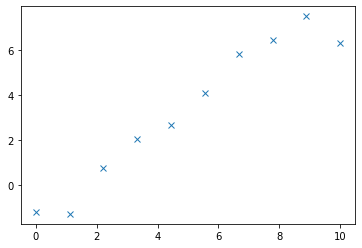

In [26]:
plt.plot(np.linspace(0, 10, 10), mu_pred, 'x')

In [27]:
v = scipy.linalg.solve_triangular(L, k_star, lower=True)
var = cov_map(sqrd_exp, np.linspace(0, 10, 10), params=par) - np.dot(v.T, v)

In [28]:
var

DeviceArray([[ 6.50554776e-01,  8.79148543e-02, -5.84813729e-02,
               4.64148214e-03, -1.13168871e-03,  1.88005404e-04,
               8.44376555e-05, -1.09673720e-05,  1.95023517e-06,
              -2.95389185e-07],
             [ 8.79148543e-02,  3.66428912e-01,  1.94216073e-01,
              -1.30435005e-02,  3.13037215e-03, -4.34893387e-04,
              -3.35259683e-04,  6.36476761e-05, -7.96704717e-06,
               1.77506263e-06],
             [-5.84813729e-02,  1.94216073e-01,  3.47065508e-01,
               8.30358267e-03, -2.78755277e-03,  2.88750557e-03,
              -2.60372134e-03,  9.00496205e-04, -6.64592735e-05,
               2.59544158e-05],
             [ 4.64148214e-03, -1.30435005e-02,  8.30358267e-03,
               8.95085931e-02,  5.40828705e-03, -4.51632589e-03,
               3.50608048e-03, -1.25958316e-03,  9.01691310e-05,
              -3.63671570e-05],
             [-1.13168871e-03,  3.13037215e-03, -2.78755277e-03,
               5.40828705e-

In [29]:
var_test = cov_map(sqrd_exp, np.linspace(0, 10, 10), params=par)

In [30]:
var_test.shape

(10, 10)

In [35]:
Kss = cov_map(sqrd_exp, np.linspace(0, 10, 10), params=par)
Kst = cov_map(sqrd_exp, np.linspace(0, 10, 10), x_train, params=par)
Ktt = cov_map(sqrd_exp, x_train, params=par)
Kts = cov_map(sqrd_exp, x_train, np.linspace(0, 10, 10), params=par)

In [36]:
cov_test = Kss - np.dot(Kst, np.dot(np.linalg.inv(Ktt), Kts))

In [37]:
Kss.shape

(10, 10)

Kernel is not psd.

In [12]:
def squared_exponential(xp, xq):
    return np.exp(-0.5*np.sum(xp - xq)**2)

In [69]:
Kss = cov_map(squared_exponential, np.linspace(0, 10, 10))
Kst = cov_map(squared_exponential, np.linspace(0, 10, 10), x_train)
Ktt = cov_map(squared_exponential, x_train, params=par)
Kts = cov_map(squared_exponential, x_train, np.linspace(0, 10, 10))

In [70]:
cov_test = Kss - np.dot(Kst, np.dot(np.linalg.inv(Ktt), Kts))

In [71]:
np.linalg.eigvals(Ktt)

DeviceArray([ 7.9746246e+00+0.0000000e+00j,  5.9919133e+00+0.0000000e+00j,
              4.2404327e+00+0.0000000e+00j,  3.1090286e+00+0.0000000e+00j,
              1.3505733e+00+0.0000000e+00j,  1.0281143e+00+0.0000000e+00j,
              9.1320437e-01+0.0000000e+00j,  2.3757449e-01+0.0000000e+00j,
              1.0539339e-01+0.0000000e+00j,  3.1329073e-02+0.0000000e+00j,
              1.4458482e-02+0.0000000e+00j,  2.4695990e-03+0.0000000e+00j,
              7.5576280e-04+0.0000000e+00j,  1.1294214e-04+0.0000000e+00j,
              2.0122978e-05+0.0000000e+00j,  3.7448488e-06+0.0000000e+00j,
              1.3629225e-06+0.0000000e+00j, -9.9948444e-08+0.0000000e+00j,
             -8.9010932e-08+3.5821738e-08j, -8.9010932e-08-3.5821738e-08j,
              1.1154956e-07+3.9923531e-08j,  1.1154956e-07-3.9923531e-08j,
              5.4745328e-08+3.1695123e-08j,  5.4745328e-08-3.1695123e-08j,
             -9.3121999e-09+0.0000000e+00j], dtype=complex64)

In [68]:
np.diag(cov_test)

DeviceArray([1.        , 0.9999923 , 0.9953944 , 0.76645553, 0.0095011 ,
             0.33126366, 0.00600863, 0.00262922, 0.00116605, 0.49072462],            dtype=float32)

There seems to be something weird going on. Let me start with kernel and redo it.
1. It could be mean, let me move the data into 0 mean catogy.
2. KERNEL might also be doing it

In [19]:
x = onp.random.choice(onp.linspace(0, 10, 100), 10)
k = np.zeros((10,10))
for i in range(0, 10):
    for j in range(0, 10):
        k = ops.index_update(k, ops.index[i,j], squared_exponential(x[i], x[j]))

In [21]:
np.linalg.eigvals(k)

DeviceArray([2.6209006e+00+0.j, 4.4493527e+00+0.j, 1.0490260e+00+0.j,
             9.7405779e-01+0.j, 3.7331805e-01+0.j, 5.0275064e-01+0.j,
             5.5258200e-03+0.j, 2.4994131e-02+0.j, 7.0829010e-05+0.j,
             2.5766471e-07+0.j], dtype=complex64)

In [22]:
np.linalg.inv(k)

DeviceArray([[ 1.0393669e+02, -2.4122520e+01,  4.7955147e+01,
              -5.0934952e+01,  3.2988861e-01,  1.2372744e-01,
              -8.5855927e+01, -2.4159134e+01, -2.6427847e-01,
               2.7216640e+01],
             [-2.4007200e+01,  4.7133394e+05, -9.0767488e+05,
               9.0142188e+05, -7.4993896e+01, -3.1287095e+03,
               1.8342859e+01,  7.9346075e+00,  2.9024053e+03,
              -4.6487366e+05],
             [ 4.7744411e+01, -9.0789931e+05,  1.7518515e+06,
              -1.7465666e+06,  1.4914200e+02,  5.9120601e+03,
              -3.6479435e+01, -1.5779968e+01, -5.7293369e+03,
               9.0244356e+05],
             [-5.0748764e+01,  9.0210112e+05, -1.7474455e+06,
               1.7558041e+06, -1.5852132e+02, -5.6671499e+03,
               3.8774952e+01,  1.6772907e+01,  5.9919883e+03,
              -9.1074675e+05],
             [ 3.2988855e-01, -7.5353188e+01,  1.4979843e+02,
              -1.5910101e+02,  1.0279359e+00,  3.8654241e-01,
        

Seems like a psd. 